In [364]:
!unzip Train_Dataset.zip

unzip:  cannot find or open Train_Dataset.zip, Train_Dataset.zip.zip or Train_Dataset.zip.ZIP.


In [365]:
!rm Train_Dataset.zip

rm: Train_Dataset.zip: No such file or directory


In [366]:
#importing neccesary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [367]:
dataset = pd.read_csv('train.csv',low_memory=False)
dataset.dtypes

ID                           object
Customer_ID                  object
Month                        object
Name                         object
Age                          object
SSN                          object
Occupation                   object
Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance              object
Credit_Score                

In [368]:

#dropping features which are not useful for determining the credit score
final_dataset = dataset.drop(["Amount_invested_monthly", "SSN", "Name", "Month", "Age", "Num_Bank_Accounts", "Num_Credit_Card", "Interest_Rate", "Type_of_Loan", "Changed_Credit_Limit", "Num_Credit_Inquiries", "Credit_Mix", "Credit_Utilization_Ratio"], axis=1)

In [369]:
dataset.to_csv('final_dataset.csv', index=False)

In [370]:
final_dataset = pd.read_csv('final_dataset.csv', low_memory=False)
x = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

In [371]:
final_dataset.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [372]:
final_dataset.shape

(100000, 28)

Cleaning errors and fixing variables

In [373]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

Deal with the missing values of Monthly_Inhand_Salary columns

In [374]:
# Convert the Customer_ID column to a factor
final_dataset['Customer_ID'] = final_dataset['Customer_ID'].astype('category')

# Calculate the median Inhand Salary by customer using groupby and summarize
median_Inhand_salary_by_customer = final_dataset.groupby('Customer_ID').agg(median_salary=('Monthly_Inhand_Salary', 'median'))

# Join the median salary column to the dataset
final_dataset = pd.merge(final_dataset, median_Inhand_salary_by_customer, on='Customer_ID', how='left')

# Replace missing values in Monthly Inhand Salary column with median salary
final_dataset['Monthly_Inhand_Salary'].fillna(final_dataset['median_salary'], inplace=True)

# Drop the median salary column
final_dataset.drop('median_salary', axis=1, inplace=True)


In [375]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   ID                        100000 non-null  object  
 1   Customer_ID               100000 non-null  category
 2   Month                     100000 non-null  object  
 3   Name                      90015 non-null   object  
 4   Age                       100000 non-null  object  
 5   SSN                       100000 non-null  object  
 6   Occupation                100000 non-null  object  
 7   Annual_Income             100000 non-null  object  
 8   Monthly_Inhand_Salary     100000 non-null  float64 
 9   Num_Bank_Accounts         100000 non-null  int64   
 10  Num_Credit_Card           100000 non-null  int64   
 11  Interest_Rate             100000 non-null  int64   
 12  Num_of_Loan               100000 non-null  object  
 13  Type_of_Loan              8859

Deal with the missing values and '_' of Num_of_Delayed_Payment 

In [376]:
# replace the '_' with ''
final_dataset['Num_of_Delayed_Payment'] = final_dataset['Num_of_Delayed_Payment'].replace('_', '', regex=True)

# convert to numeric
final_dataset['Num_of_Delayed_Payment'] = final_dataset['Num_of_Delayed_Payment'].astype(float)

In [377]:
# Calculate the median delayed payments by customer using groupby and summarize
median_delayed_by_customer = final_dataset.groupby('Customer_ID').agg(median_delayed=('Num_of_Delayed_Payment', 'median'))

# Join the median delayed payments column to the dataset
final_dataset = pd.merge(final_dataset, median_delayed_by_customer, on='Customer_ID', how='left')

# Replace missing values in Num of Delayed Payment column with median delayed payments
final_dataset['Num_of_Delayed_Payment'].fillna(final_dataset['median_delayed'], inplace=True)


# Drop the median delayed payments column
final_dataset.drop('median_delayed', axis=1, inplace=True)

In [378]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   ID                        100000 non-null  object  
 1   Customer_ID               100000 non-null  category
 2   Month                     100000 non-null  object  
 3   Name                      90015 non-null   object  
 4   Age                       100000 non-null  object  
 5   SSN                       100000 non-null  object  
 6   Occupation                100000 non-null  object  
 7   Annual_Income             100000 non-null  object  
 8   Monthly_Inhand_Salary     100000 non-null  float64 
 9   Num_Bank_Accounts         100000 non-null  int64   
 10  Num_Credit_Card           100000 non-null  int64   
 11  Interest_Rate             100000 non-null  int64   
 12  Num_of_Loan               100000 non-null  object  
 13  Type_of_Loan              8859

Deal with the missing values and '_' of Monthly_Balance

In [379]:
# replace the '_' with ''
final_dataset['Monthly_Balance'] = final_dataset['Monthly_Balance'].replace('_', '', regex=True)
# convert to numeric
final_dataset['Monthly_Balance'] = final_dataset['Monthly_Balance'].astype(float)

In [380]:
# Calculate the median delayed payments by customer using groupby and summarize
median_Monthly_Balance_customer = final_dataset.groupby('Customer_ID').agg(median_Monthly_Balance=('Monthly_Balance', 'median'))

# Join the median delayed payments column to the dataset
final_dataset = pd.merge(final_dataset, median_Monthly_Balance_customer, on='Customer_ID', how='left')

# Replace missing values in Num of Delayed Payment column with median delayed payments
final_dataset['Monthly_Balance'].fillna(final_dataset['median_Monthly_Balance'], inplace=True)

# Drop the median delayed payments column
final_dataset.drop('median_Monthly_Balance', axis=1, inplace=True)

In [381]:
final_dataset.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.494089,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.629162,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.209863,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.451310,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.489231,Good


In [382]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   ID                        100000 non-null  object  
 1   Customer_ID               100000 non-null  category
 2   Month                     100000 non-null  object  
 3   Name                      90015 non-null   object  
 4   Age                       100000 non-null  object  
 5   SSN                       100000 non-null  object  
 6   Occupation                100000 non-null  object  
 7   Annual_Income             100000 non-null  object  
 8   Monthly_Inhand_Salary     100000 non-null  float64 
 9   Num_Bank_Accounts         100000 non-null  int64   
 10  Num_Credit_Card           100000 non-null  int64   
 11  Interest_Rate             100000 non-null  int64   
 12  Num_of_Loan               100000 non-null  object  
 13  Type_of_Loan              8859

Dealing with the missing value in Credit_History_Age column

In [383]:
# Define function to convert string to number of months
def convert_to_months(s):
    # If value is null or empty, return default value 0
    if pd.isna(s) or s.strip() == "":
        return 0
    # Split string into years and months
    years, months = s.split(" Years and ")
    months = months.replace(" Months", "")
    # Convert to total months
    total_months = int(years) * 12 + int(months)
    return total_months

# Apply the function to the "age" column and create a new column "age_in_months"
final_dataset["Credit_History_Age"] = final_dataset["Credit_History_Age"].apply(convert_to_months)

In [384]:
# Calculate the median credit history age by customer using groupby and summarize
median_credit_history_age_customer = final_dataset.groupby('Customer_ID').agg(median_credit_history_age=('Credit_History_Age', 'median'))

# Join the median credit history age column to the dataset
final_dataset = pd.merge(final_dataset, median_credit_history_age_customer, on='Customer_ID', how='left')

# Replace rows with a value of 0 in Credit History Age column with median credit history age
final_dataset['Credit_History_Age'] = final_dataset['Credit_History_Age'].apply(lambda x: final_dataset['median_credit_history_age'][x] if x == 0 else x)

# Drop the median credit history age column
final_dataset.drop('median_credit_history_age', axis=1, inplace=True)

In [385]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   ID                        100000 non-null  object  
 1   Customer_ID               100000 non-null  category
 2   Month                     100000 non-null  object  
 3   Name                      90015 non-null   object  
 4   Age                       100000 non-null  object  
 5   SSN                       100000 non-null  object  
 6   Occupation                100000 non-null  object  
 7   Annual_Income             100000 non-null  object  
 8   Monthly_Inhand_Salary     100000 non-null  float64 
 9   Num_Bank_Accounts         100000 non-null  int64   
 10  Num_Credit_Card           100000 non-null  int64   
 11  Interest_Rate             100000 non-null  int64   
 12  Num_of_Loan               100000 non-null  object  
 13  Type_of_Loan              8859

Dealing with Occupation column

In [386]:
final_dataset['Occupation'].value_counts()

_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: Occupation, dtype: int64

In [387]:
# Remove rows where the "Occupation" column has the value "_______"
final_dataset = final_dataset[~(final_dataset['Occupation'] == '_______')]
final_dataset['Occupation'].value_counts()

Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: Occupation, dtype: int64

Dealing with Annual Income column

In [388]:
final_dataset['Annual_Income'].value_counts()

36585.12      16
17273.83      15
9141.63       15
17816.75      14
95596.35      14
              ..
39883.46_      1
14773.91_      1
14059195.0     1
14365.54_      1
16857.295_     1
Name: Annual_Income, Length: 18560, dtype: int64

In [389]:
# Remove rows where the "Annual_Income" column has the value "_"
final_dataset['Annual_Income'] = final_dataset['Annual_Income'].str.replace('_', '')
# Converting "Annual_Income" column to numeric
#final_dataset['Annual_Income'] = pd.to_(final_dataset['Annual_Income'],errors='coerce')
final_dataset['Annual_Income'].value_counts()


36585.12      16
40341.16      15
17816.75      15
9141.63       15
109945.32     15
              ..
8681121.0      1
12083640.0     1
20703498.0     1
3301922.0      1
11603023.0     1
Name: Annual_Income, Length: 13409, dtype: int64

In [390]:
# Adjust incorrect data entries
sym = '\\`*_{}[]()>#@+!$:;'
col_int = ['Age','Annual_Income','Delay_from_due_date','Num_of_Delayed_Payment',
           'Outstanding_Debt','Total_EMI_per_month', 'Monthly_Balance']

col_str = ['Occupation', 'Credit_History_Age','Payment_of_Min_Amount','Credit_Score']

for i in col_int:
    for c in sym:
        final_dataset[i] = final_dataset[i].astype(str).str.replace(c,'')
        
for i in col_str:
    for c in sym:
        final_dataset[i] = final_dataset[i].replace(c,'')

/var/folders/nf/g_4jhvds3hl6w0x8k1y827z80000gn/T/ipykernel_81646/3464933554.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  final_dataset[i] = final_dataset[i].astype(str).str.replace(c,'')


Dealing with Credit Score column

In [391]:
final_dataset['Credit_Score'].value_counts()

Standard    49386
Poor        26967
Good        16585
Name: Credit_Score, dtype: int64

Dealing with Payment Behaviour column

In [392]:
final_dataset['Payment_Behaviour'].value_counts()

Low_spent_Small_value_payments      23720
High_spent_Medium_value_payments    16301
Low_spent_Medium_value_payments     12882
High_spent_Large_value_payments     12767
High_spent_Small_value_payments     10524
Low_spent_Large_value_payments       9658
!@9#%8                               7086
Name: Payment_Behaviour, dtype: int64

In [393]:
# Remove rows where the "Payment_Behaviour" column has the value "!@9#%8"
final_dataset = final_dataset[~(final_dataset['Payment_Behaviour'] == '!@9#%8')]

In [394]:
final_dataset['Payment_Behaviour'].value_counts()

Low_spent_Small_value_payments      23720
High_spent_Medium_value_payments    16301
Low_spent_Medium_value_payments     12882
High_spent_Large_value_payments     12767
High_spent_Small_value_payments     10524
Low_spent_Large_value_payments       9658
Name: Payment_Behaviour, dtype: int64

In [395]:
final_dataset["Payment_Behaviour"] = final_dataset["Payment_Behaviour"].replace({"High_spent_Large_value_payments": 6,
                                                                       "High_spent_Medium_value_payments": 5,
                                                                       "High_spent_Small_value_payments": 4,
                                                                       "Low_spent_Large_value_payments": 3,
                                                                       "Low_spent_Medium_value_payments": 2,
                                                                       "Low_spent_Small_value_payments": 1})


In [396]:
final_dataset["Payment_Behaviour"].value_counts()

1    23720
5    16301
2    12882
6    12767
4    10524
3     9658
Name: Payment_Behaviour, dtype: int64

Dealing with Total_EMI_per_month column

In [397]:
final_dataset['Total_EMI_per_month'].value_counts()

0.0                  9051
94.7879956533391        8
78.74971305050755       8
27.55586581342608       8
81.82285657517096       8
                     ... 
991.0                   1
19940.0                 1
12598.0                 1
23135.0                 1
58638.0                 1
Name: Total_EMI_per_month, Length: 14445, dtype: int64

Dealing with the Payment_of_Min_Amount column

In [398]:
final_dataset['Payment_of_Min_Amount'].value_counts()

Yes    44892
No     30635
NM     10325
Name: Payment_of_Min_Amount, dtype: int64

In [399]:
final_dataset['Payment_of_Min_Amount'] = final_dataset['Payment_of_Min_Amount'].replace({"No": 2,
                                                                       "Yes": 1,
                                                                       "NM": 0})

In [400]:
final_dataset['Payment_of_Min_Amount'].value_counts()

1    44892
2    30635
0    10325
Name: Payment_of_Min_Amount, dtype: int64

Dealing with Outstanding_Debt column

In [401]:
final_dataset['Outstanding_Debt'].value_counts()

1151.7     24
1360.45    21
460.46     21
1109.03    20
804.31     16
           ..
884.52      2
1424.12     2
829.3       2
1661.55     1
45.65       1
Name: Outstanding_Debt, Length: 12203, dtype: int64

In [402]:
# Remove rows where the "Outstanding_Debt" column has the value "_"
#final_dataset['Outstanding_Debt'] = final_dataset['Outstanding_Debt'].str.replace('_', '')
# Converting "Outstanding_Debt" column to numeric
#final_dataset['Outstanding_Debt'] = pd.to_numeric(final_dataset['Outstanding_Debt'],errors='coerce')


int_col = ['Delay_from_due_date','Num_of_Delayed_Payment','Outstanding_Debt',
           'Total_EMI_per_month','Monthly_Balance','Payment_Behaviour','Credit_History_Age','Annual_Income']

for i in int_col:
    final_dataset[i] = final_dataset[i].astype(float)

In [403]:
final_dataset['Outstanding_Debt'].value_counts()

1151.70    24
1360.45    21
460.46     21
1109.03    20
804.31     16
           ..
884.52      2
1424.12     2
829.30      2
1661.55     1
45.65       1
Name: Outstanding_Debt, Length: 12203, dtype: int64

Dealing with Delay_from_due_date column

In [404]:
final_dataset['Delay_from_due_date'].value_counts()

 15.0    3096
 13.0    2903
 14.0    2846
 8.0     2839
 10.0    2801
         ... 
-4.0       52
 65.0      47
 66.0      28
-5.0       27
 67.0      19
Name: Delay_from_due_date, Length: 73, dtype: int64

In [405]:
final_dataset.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,265.0,2,49.574949,80.41529543900253,4.0,312.494089,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,31.944960,267.5,2,49.574949,118.28022162236736,3.0,284.629162,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,28.609352,267.0,2,49.574949,81.699521264648,2.0,331.209863,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,31.377862,268.0,2,49.574949,199.4580743910713,1.0,223.451310,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,269.0,2,49.574949,41.420153086217326,5.0,341.489231,Good


In [406]:
final_dataset['Delay_from_due_date'].value_counts()

 15.0    3096
 13.0    2903
 14.0    2846
 8.0     2839
 10.0    2801
         ... 
-4.0       52
 65.0      47
 66.0      28
-5.0       27
 67.0      19
Name: Delay_from_due_date, Length: 73, dtype: int64

Dealing with the Num_of_Loan column

In [407]:
final_dataset['Num_of_Loan'].value_counts()

3        12340
2        12302
4        12049
0         8842
1         8681
         ...  
252          1
745          1
1320_        1
103          1
966          1
Name: Num_of_Loan, Length: 378, dtype: int64

In [408]:
final_dataset.loc[final_dataset['Num_of_Loan'] == "-100", 'Num_of_Loan'] = np.nan

In [410]:
# Calculate the median Num_of_Loan by customer using groupby and summarize
#median_Num_of_Loan_customer = final_dataset.groupby('Customer_ID').agg(median_Num_of_Loan=('Num_of_Loan', 'median'))

# Join the median Num_of_Loan column to the dataset
final_dataset = pd.merge(final_dataset, median_Num_of_Loan_customer, on='Customer_ID', how='left')

# Replace rows with a value of 0 in Num_of_Loan column with median credit history age
final_dataset['Num_of_Loan'].fillna(final_dataset['median_Num_of_Loan'], inplace=True)

# Drop the median Num_of_Loan column
final_dataset.drop('median_Num_of_Loan', axis=1, inplace=True)


In [411]:
final_dataset.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,265.0,2,49.574949,80.41529543900253,4.0,312.494089,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,31.944960,267.5,2,49.574949,118.28022162236736,3.0,284.629162,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,28.609352,267.0,2,49.574949,81.699521264648,2.0,331.209863,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,31.377862,268.0,2,49.574949,199.4580743910713,1.0,223.451310,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,269.0,2,49.574949,41.420153086217326,5.0,341.489231,Good


In [412]:
#Using the Inter Quantile Range to drop outliers
Q1 = final_dataset.Annual_Income.quantile(0.25)
Q3 = final_dataset.Annual_Income.quantile(0.75)

IQR = Q3 - Q1
final_dataset = final_dataset.drop(final_dataset.loc[final_dataset['Annual_Income'] > (Q3 + 1.5 * IQR)].index)
final_dataset = final_dataset.drop(final_dataset.loc[final_dataset['Annual_Income'] < (Q1-1.5*IQR)].index)

<AxesSubplot:xlabel='Annual_Income'>

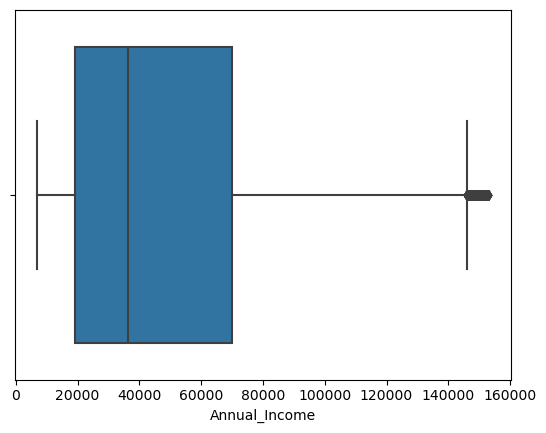

In [414]:
sns.boxplot(x=final_dataset['Annual_Income'])

<AxesSubplot:xlabel='Credit_History_Age'>

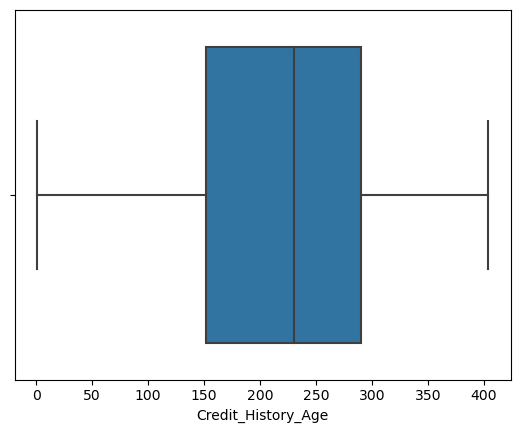

In [415]:
sns.boxplot(x=final_dataset['Credit_History_Age'])

<AxesSubplot:xlabel='Outstanding_Debt'>

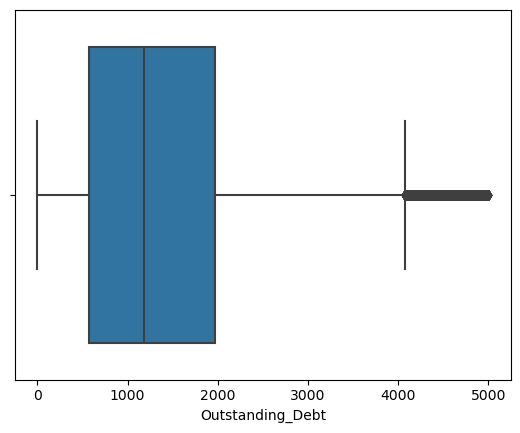

In [416]:
sns.boxplot(x=final_dataset['Outstanding_Debt'])

In [420]:
#Occupation count
counting_occupation = final_dataset['Occupation'].value_counts(dropna=False)


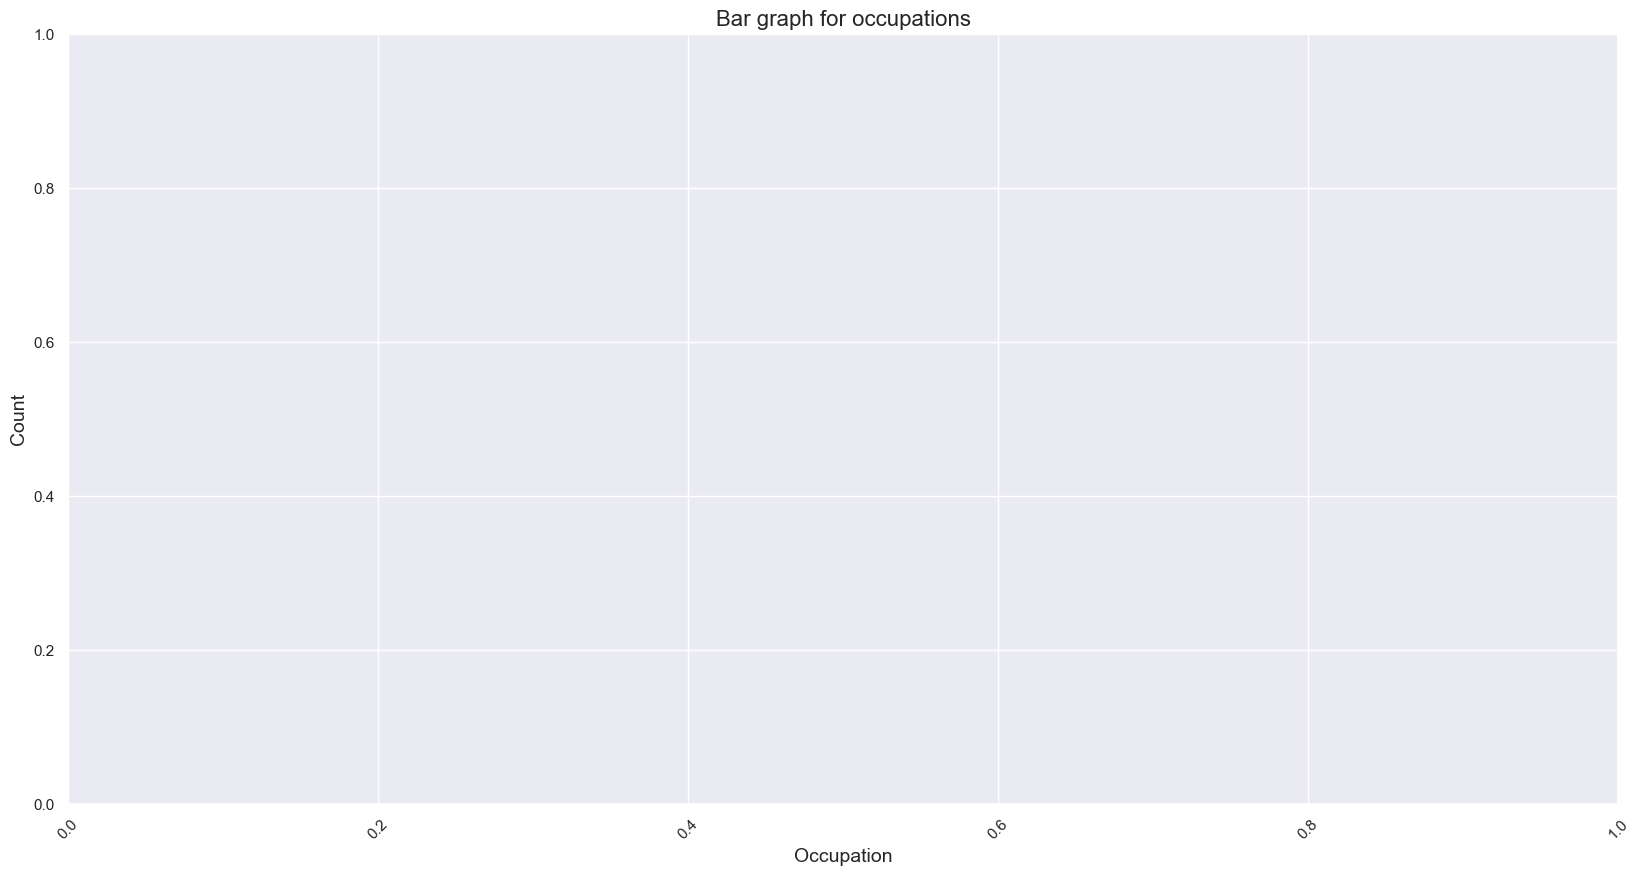

In [421]:
#Bar graph for occupations
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x=counting_occupation)
plt.title('Bar graph for occupations', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Occupation', fontsize=14)
plt.xticks(rotation=45)
plt.show()

Lets work on the outliers in different columns like "Num_of_Delayed_Payment", "Total_EMI_per_month", "Num_of_Loan" and "Annual_Income"

In [125]:
#sorted(final_dataset['Num_of_Delayed_Payment'])

In [126]:
#quantile1, quantile3 = np.percentile(final_dataset['Num_of_Delayed_Payment'],[25,75])

In [127]:
#print(quantile1,quantile3)

In [128]:
#iqr_value = quantile3 - quantile1
#print(iqr_value)

In [129]:
#lowerbound = quantile1 - (1.5 * iqr_value)
#upperbound = quantile3 + (1.5 * iqr_value)
#print(lowerbound,upperbound)